<a href="https://colab.research.google.com/github/vulture990/OCR-using-CRNN/blob/main/model_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Recognition Of Handwritten from An Image.**
 (Using Convolutional Recurrent Neural Network known as CRNN)

## **Intro: **
An optical character recognition (OCR) is recognising letters from an image and detecting that text . For A sequence recognition with that results in many predictions, the most suited neural networks are recurrent neural networks(RNN)  and For an image-based recognition the most suited approach are convolution neural networks(CNN). For an ultimate approach to tackle the problems and have a good Accuracy to our OCR Model we need to combine both of these CNN and RNN.
Hence the name Convolutional Recurrent Neural Networks (CRNN).

Here are few steps i ll try to follow to build CRNN:

1-   Collecting Dataset(I m going to be working with an amazing rich dataset called IAM imported to the drive to mount it in GOOGLEColab )
2-   Preprocessing 
3-   Creating The CRNN
4-   Loss Function
5-   Training  The Model
6-   Test The Model
7-   Accuracy and Loss.
8-   Enhance The Model Preformance
9-  Save the Model.

**I uploaded IAM datset of words .**

For more details of how to upload datset [click here](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database).


## **Importing  packages such as some keras 3d party libs**

**Installing Keras_tqdm.**

In [1]:
!pip install keras_tqdm

In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import os
import keras.backend as K
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
from keras.utils import *
from google.colab import drive #This one is to acess to your drive
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

**We Will Mount the dirve first set the path**


**This code to extract depending on your location of where u v putted the file the file.**


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil
shutil.unpack_archive("drive/MyDrive/ColabNotebooks/words.tgz.tar", "/Data") #/Data is the path where the files will be extracted u can mkdir your folder and extract in any place u want

In [6]:
import tensorflow as tf

#ignore warnings 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## **Tensorflow GPU**

Checking Google Colab's GPU cuz i ve used it to train faster


**This step is to check GPU is available or not.**

In [7]:
tf.config.experimental.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
cd ..


/


In [10]:

!ls

bin	 Data	  etc	lib32  mnt   root  srv		      tmp    var
boot	 datalab  home	lib64  opt   run   sys		      tools
content  dev	  lib	media  proc  sbin  tensorflow-1.15.2  usr


## **Preprocessing**
Now That we are having our dataset, we need to make it more acceptable  for our model we need to use some preprocessing. We need to preprocess both the input image and output labels. 
To preprocess our input image we will use followings:
Read the image and transform it into a gray-scale image with opencv
Make each image of size (128,32) by using padding 
Expand image dimension as (128,32,1) to make it compatible with the input shape of architecture
Normalize the image pixel values by dividing it with 255.
To preprocess the output labels use the followings:
Read the text from the words.txt file because it contains text written inside the image. Which is in the format 'a01-000u-00-00 ok 154 408 768 27 51 AT A'.
Compute the maximum length from words and pad every output label to make it of the same size as the maximum length. This is done to make it compatible with the output shape of our RNN architecture. Then finnaly converts it to a numpy array.








**Loading words.txt file in this function.**

In [11]:
drive.mount('/content/drive')
with open('content/drive/My Drive/ColabNotebooks/words.txt') as f:
    contents = f.readlines()
lines = [line.strip() for line in contents] 
lines[0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [12]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [13]:
images = []
labels = []
RECORDS_COUNT = 10000

In [14]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [15]:
def process_image(img):
    """
    We Should Converts the image to shape (32, 128, 1) & normalize it
    """
    w, h = img.shape
    
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # The normalazing part can be done easily in 
    img = img / 255
    
    return img

**Train and Validation**



In [16]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        #Cuz we named the folder where we extracted Data
        filepath = 'Data/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # processing  images
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # processing labels
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [17]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [18]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

**Convert to numpy array.**
*   images = np.asarray(images)
*   inputs_length = np.asarray(inputs_length)
*   labels_length = np.asarray(labels_length)

In [19]:

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [20]:
train_images.shape

(7850, 32, 128, 1)

## **Build The Model.**
(Using Convolutional Recurrent Neural Network)

This network architecture is inspired by [this paper](https://arxiv.org/pdf/1507.05717.pdf). Let’s see the steps that we used to build this model:

Input shape for our architecture having an input image of height 32 and width 128.
Here we used 7 convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). And the number of filters is increased from 64 to 512 layer by layer.
Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts.
Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training process.
Then we used a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer.
Then used two Bidirectional LSTM layers each of which has 128 units. This RNN layer gives the output of size (batch_size, 31, 63). Where 63 is the total number of output classes including blank character.

In [21]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [22]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

## **Loss Function**
Here, we are using the CTC loss function. CTC loss is very helpful in text recognition problems. It helps us to prevent annotating each time step and help us to get rid of the problem where a single character can span multiple time step which needs further processing if we do not use CTC. 

A CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. To get this we need to create a custom loss function and then pass it to the model. To make it compatible with our model, we will create a model which takes these four inputs and outputs the loss. This model will be used for training and for testing we will use the model that we have created earlier “act_model”. Let’s see the code:

In [23]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

## **Train the Model**
To train the model we will use Adam optimizer. Also, we can use Keras callbacks functionality to save the weights of the best model on the basis of validation loss. In model.compile(), you can see that I have only taken y_pred and neglected y_true. This is because I have already taken labels as input to the model earlier. labels as input to the model earlier.

Now train your model on 7850 training images and 876 validation images.

In [26]:
batch_size = 8
epochs = 50
e = str(epochs)
optimizer_name = 'sgd'

In [27]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="drive/My Drive/ColabNotebooks/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [28]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/50
982/982 - 84s - loss: 15.5677 - accuracy: 0.0000e+00 - val_loss: 14.6227 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 14.62271, saving model to drive/My Drive/ColabNotebooks/sgdo-10000r-50e-7850t-876v.hdf5
Epoch 2/50
982/982 - 23s - loss: 12.8989 - accuracy: 0.0183 - val_loss: 14.0114 - val_accuracy: 0.0457

Epoch 00002: val_loss improved from 14.62271 to 14.01137, saving model to drive/My Drive/ColabNotebooks/sgdo-10000r-50e-7850t-876v.hdf5
Epoch 3/50
982/982 - 24s - loss: 11.1251 - accuracy: 0.0586 - val_loss: 14.0299 - val_accuracy: 0.0388

Epoch 00003: val_loss did not improve from 14.01137
Epoch 4/50
982/982 - 24s - loss: 9.2322 - accuracy: 0.1010 - val_loss: 12.7608 - val_accuracy: 0.0377

Epoch 00004: val_loss improved from 14.01137 to 12.76081, saving model to drive/My Drive/ColabNotebooks/sgdo-10000r-50e-7850t-876v.hdf5
Epoch 5/50
982/982 - 23s - loss: 7.3335 - accuracy: 0.1473 - val_loss: 7.8095 - val_accuracy: 0.1781

Epoch 00005: val_los

## **Test the Model**
Our model is now trained with 7850 images. Now its time to test the model. We can not use our training model because it also requires labels as input and at test time we can not have labels. So to test the model we will use ” act_model ” that we have created earlier which takes only one input: test images.

As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Here we used the CTC decoder to get the output text. Let’s see the code:

We use Jaro Distance & Ratio method to test accuracy.

**Installing Levenshtein package in google colab.**

In [24]:
!pip install python-levenshtein

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149816 sha256=960e930761788d8372ba4d3e34cac0e64392ec13c85c427c6b18fff1b8cf4b3c
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-levenshtein


In [29]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

jaro : 0.9039410519718738
ratio: 0.869250960455118


**Prediction.**

original_text =   We
predicted text = We

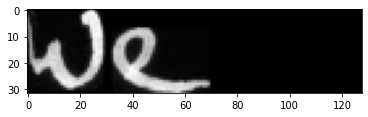



original_text =   want
predicted text = want

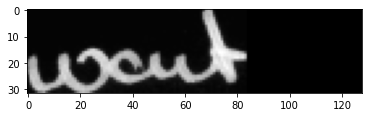



original_text =   to
predicted text = to

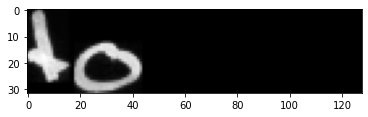



original_text =   discuss
predicted text = discuss

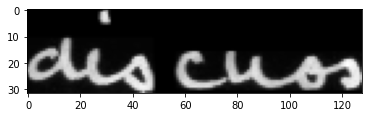



original_text =   what
predicted text = what

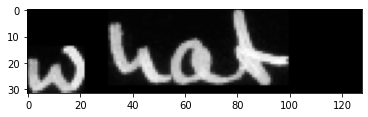



original_text =   do
predicted text = do

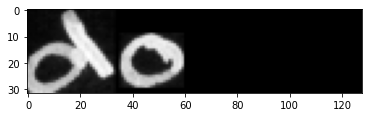



original_text =   if
predicted text = if

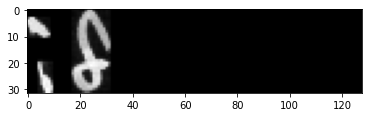



original_text =   the
predicted text = the

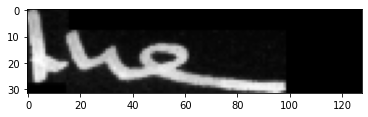



original_text =   British
predicted text = British

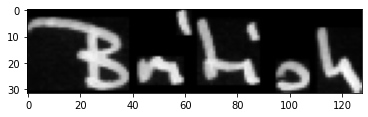



original_text =   demonstrations
predicted text = demonstrations

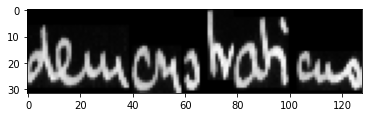



original_text =   .
predicted text = .

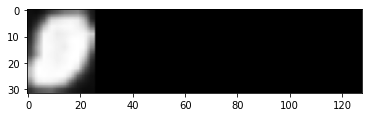



original_text =   "
predicted text = "

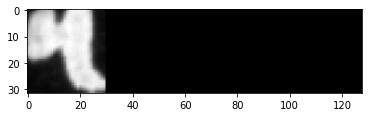



original_text =   Yesterday
predicted text = yesterday

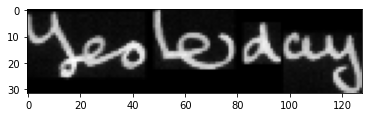



original_text =   Sir
predicted text = Sir

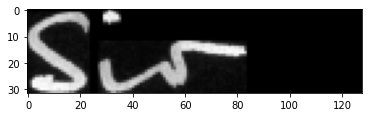



original_text =   chief
predicted text = chief

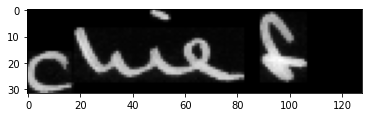



original_text =   aide
predicted text = aide

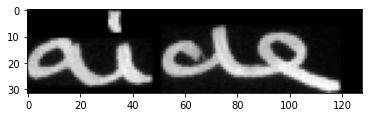



original_text =   ,
predicted text = ,

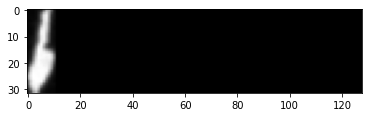



original_text =   Mr.
predicted text = Mr.

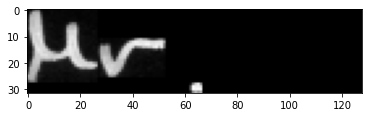



original_text =   Julius
predicted text = Julius

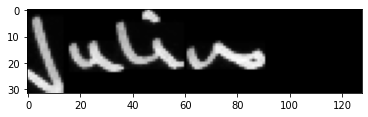



original_text =   Greenfield
predicted text = Greenfield

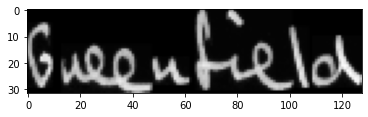



original_text =   ,
predicted text = ,

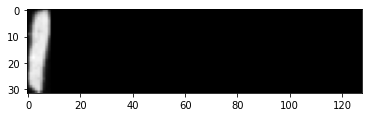



original_text =   telephoned
predicted text = telephoned

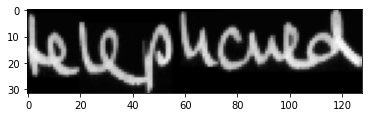



original_text =   his
predicted text = his

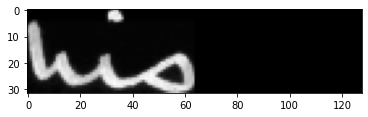



original_text =   a
predicted text = a

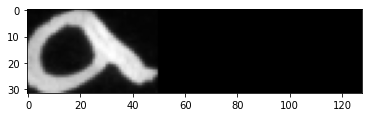



original_text =   report
predicted text = report

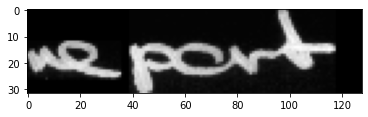



original_text =   on
predicted text = on

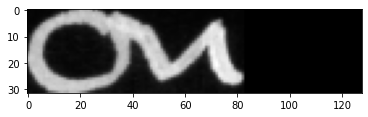



original_text =   his
predicted text = his

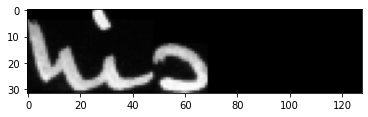



original_text =   talks
predicted text = talk

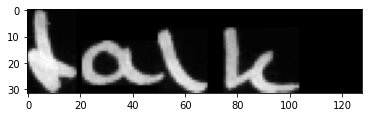



original_text =   with
predicted text = with

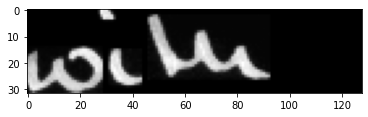



original_text =   Mr.
predicted text = Mr.

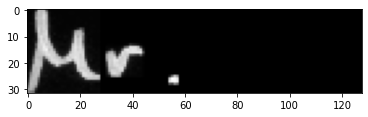



original_text =   Macmillan
predicted text = Macmilan

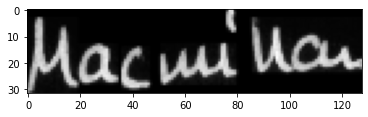



original_text =   at
predicted text = at

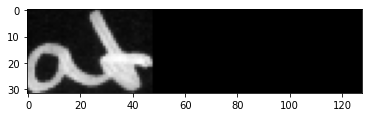



original_text =   .
predicted text = .

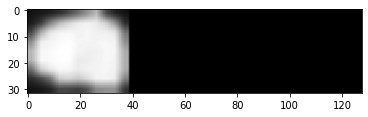



original_text =   Sir
predicted text = Sir

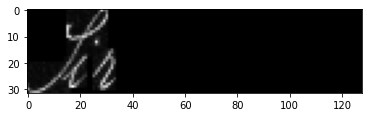



original_text =   Roy's
predicted text = Roys

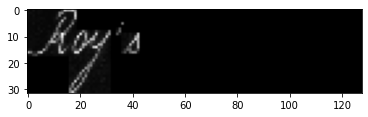



original_text =   United
predicted text = Uniled

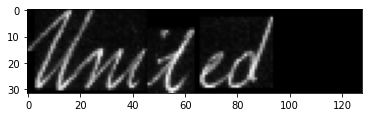



original_text =   Federal
predicted text = Federal

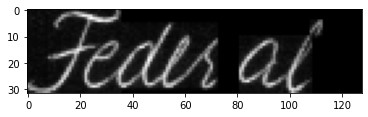



original_text =   Party
predicted text = Party

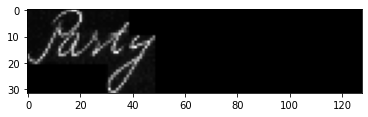



original_text =   is
predicted text = is

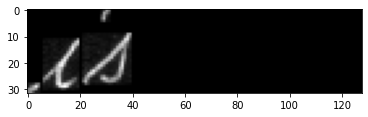



original_text =   boycotting
predicted text = boyuotting

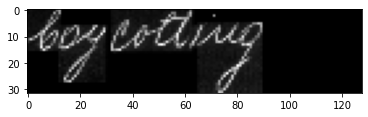



original_text =   the
predicted text = the

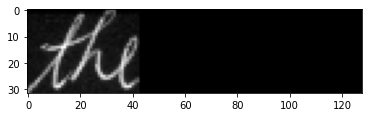



original_text =   talks
predicted text = talks

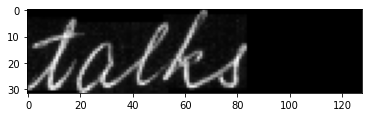



original_text =   on
predicted text = on

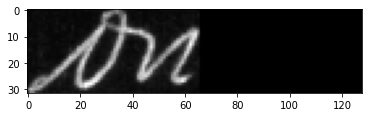



original_text =   the
predicted text = the

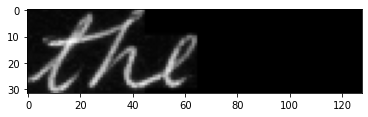



original_text =   Protectorate's
predicted text = Protectorate's

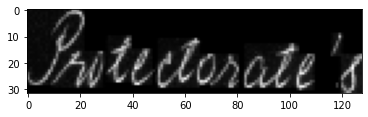



original_text =   future
predicted text = future

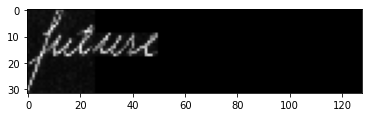



original_text =   .
predicted text = .

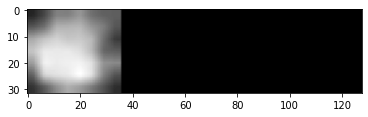



original_text =   Said
predicted text = Said

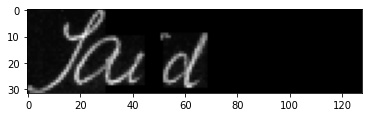



original_text =   Mr.
predicted text = Mr.

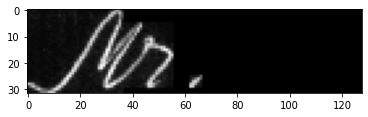



original_text =   Nkumbula
predicted text = Mkumbula

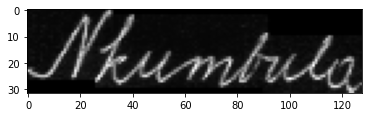



original_text =   night
predicted text = night

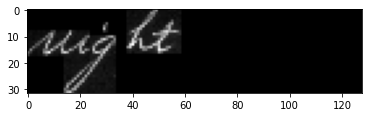



original_text =   :
predicted text = .

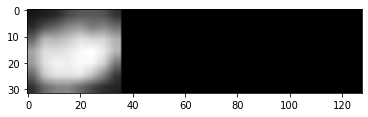



original_text =   "
predicted text = "

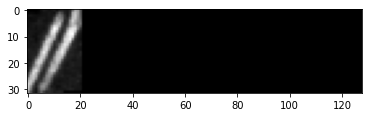



original_text =   We
predicted text = We

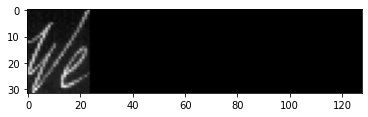



original_text =   want
predicted text = want

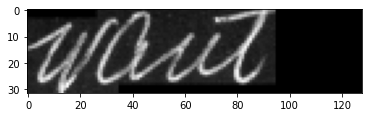



original_text =   to
predicted text = to

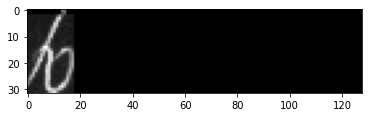



original_text =   discuss
predicted text = discuss

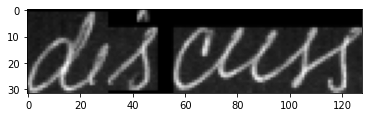



original_text =   what
predicted text = what

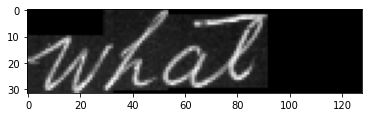



original_text =   to
predicted text = to

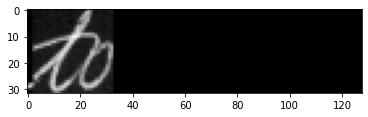



original_text =   if
predicted text = if

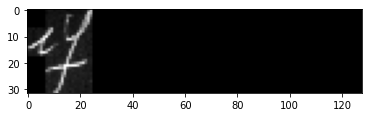



original_text =   the
predicted text = the

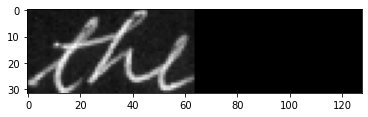



original_text =   British
predicted text = British

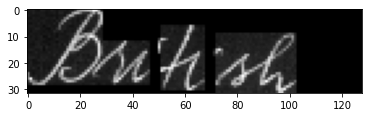



original_text =   Government
predicted text = Gorernmene

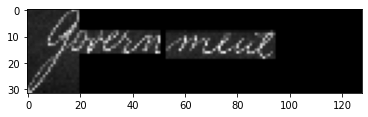



original_text =   gives
predicted text = gives

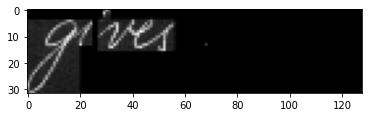



original_text =   in
predicted text = in

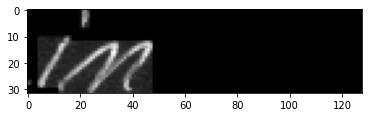



original_text =   to
predicted text = to

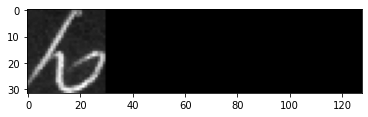



original_text =   Sir
predicted text = Sirs

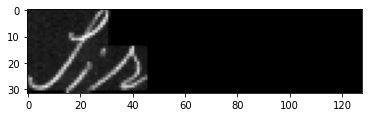



original_text =   Roy
predicted text = Roy

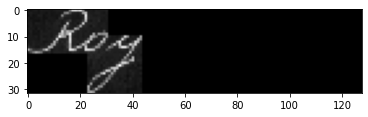



original_text =   the
predicted text = the

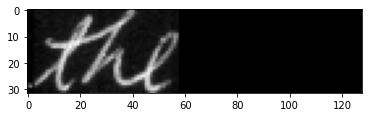



original_text =   talks
predicted text = talks

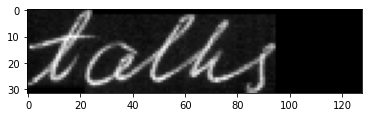



original_text =   fall
predicted text = fall

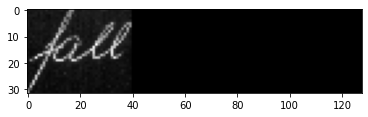



original_text =   through
predicted text = though

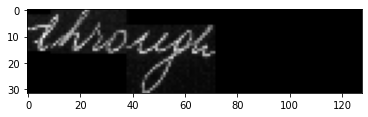



original_text =   .
predicted text = .

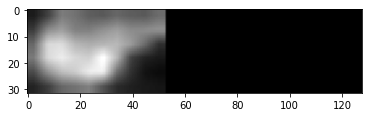



original_text =   There
predicted text = Thure

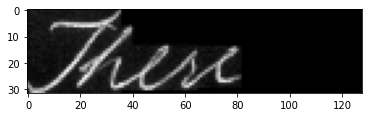



original_text =   are
predicted text = are

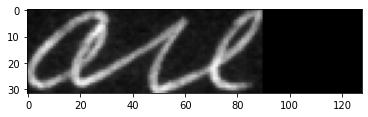



original_text =   bound
predicted text = bound

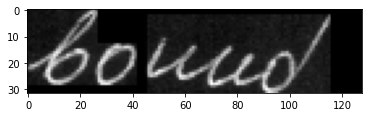



original_text =   to
predicted text = to

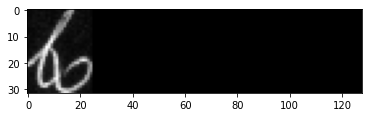



original_text =   demonstrations
predicted text = demonstrarions

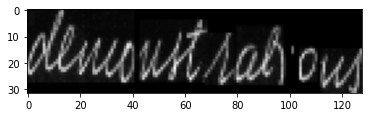



original_text =   .
predicted text = .

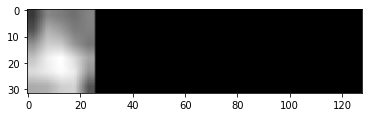



original_text =   "
predicted text = "

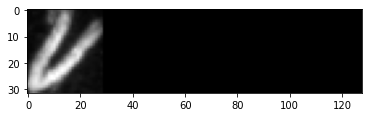



original_text =   Yesterday
predicted text = yesterday

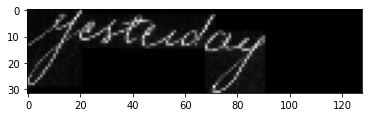



original_text =   Sir
predicted text = Sir

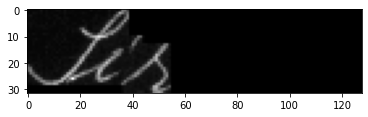



original_text =   Roy's
predicted text = Roys

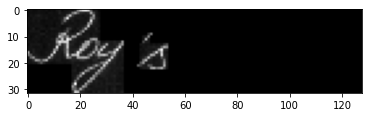



original_text =   chief
predicted text = chief

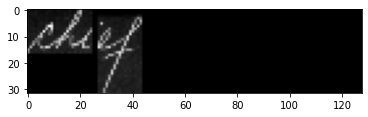



original_text =   aide
predicted text = aide

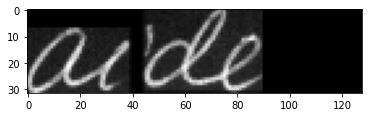



original_text =   ,
predicted text = ,

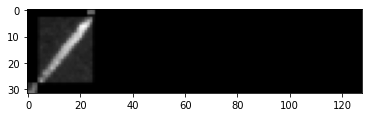



original_text =   Julius
predicted text = Gulius

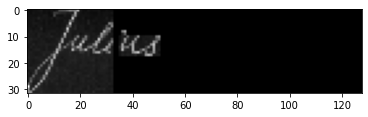



original_text =   Greenfield
predicted text = Greenfield

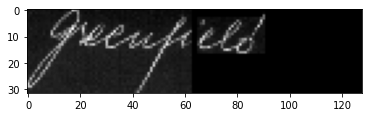



original_text =   ,
predicted text = ,

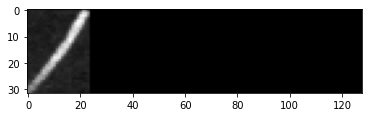



original_text =   telephoned
predicted text = relephoned

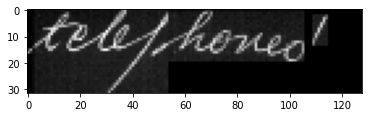



original_text =   his
predicted text = his

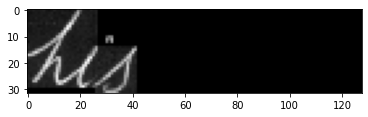



original_text =   chief
predicted text = chiet

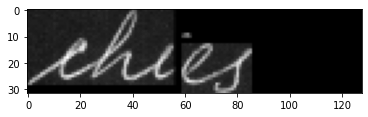



original_text =   a
predicted text = a

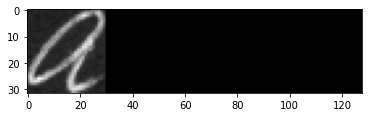



original_text =   report
predicted text = yeortt

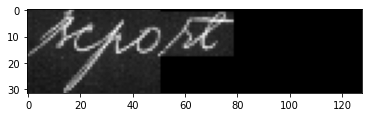



original_text =   on
predicted text = on

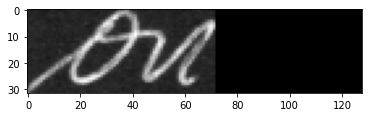



original_text =   talks
predicted text = talks

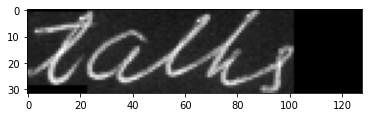



original_text =   with
predicted text = with

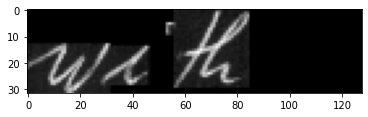



original_text =   Mr.
predicted text = Mr.

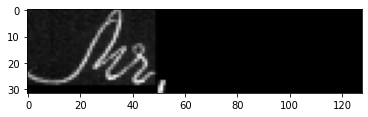



original_text =   Macmillan
predicted text = Macmillan

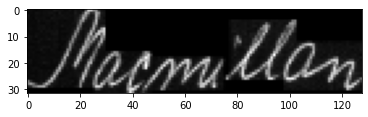



original_text =   at
predicted text = at

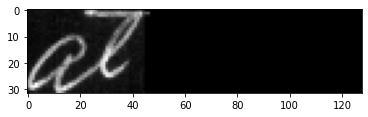



original_text =   Chequers
predicted text = Cheuers

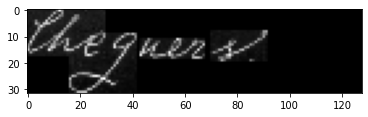



original_text =   .
predicted text = .

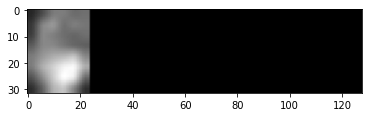



original_text =   Mr.
predicted text = Mr.

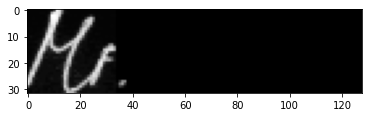

In [30]:
# predict outputs on validation images
prediction =act_model.predict(train_images[642:745])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[642+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[642+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

## **Plot Accuracy and Loss**

In [31]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [32]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

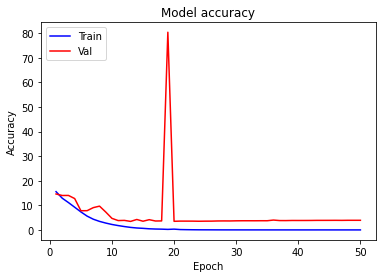

In [33]:
plotgraph(epochs, loss, val_loss)

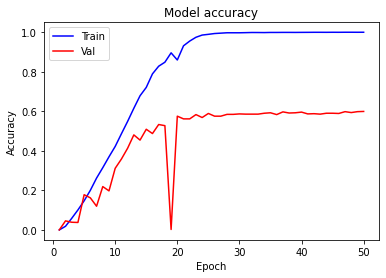

In [34]:
plotgraph(epochs, acc, val_acc)

## **Enhancing The Model**

In [35]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [36]:
with open('drive/My Drive/ColabNotebooks/history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)

## **Save the Model.**

In [37]:
model.save('drive/My Drive/ColabNotebooks/Text_recognizer_CRNN.h5')